In [1]:

!pip install tensorflow opencv-python-headless pandas numpy scikit-learn



In [2]:
# දත්ත Unzip කිරීම
!unzip -q dataset.zip -d .
print("Unzip සම්පූර්ණයි.")

Unzip සම්පූර්ණයි.


In [3]:
import pandas as pd
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# --- 1. දත්ත සහ ෆෝල්ඩර නිවැරදිව සොයා ගැනීම ---
root_dir = "."
csv_path = "labels.csv"
images_dir = "images"

print(f"Checking for files in: {os.getcwd()}")

if not os.path.exists(csv_path):
    raise FileNotFoundError("Error: labels.csv ගොනුව සොයාගත නොහැක.")
if not os.path.exists(images_dir):
    raise FileNotFoundError("Error: images ෆෝල්ඩරය සොයාගත නොහැක.")

# CSV කියවීම
df = pd.read_csv(csv_path)


df['filename'] = df['filename'].str.replace('\\', '/', regex=False)

# --- දත්ත පෙර සැකසීම ---
images = []
labels_consonant = []
labels_modifier = []

IMG_SIZE = 64

print(f"CSV ගොනුවේ ඇති මුළු රූප ගණන: {len(df)}")
print("රූප කියවීම ආරම්භ කරයි...")

loaded_count = 0
for index, row in df.iterrows():
    # රූපයේ නම CSV එකෙන් ගෙන, එය images ෆෝල්ඩරය තුළ සොයයි
    # උදාහරණය: "images" + "A/img_001.png" -> "images/A/img_001.png"
    img_path = os.path.join(images_dir, row['filename'])

    # Debug: පළමු රූපයේ path එක පෙන්වන්න (එය හරිදැයි බැලීමට)
    if index == 0:
        print(f"First image path being checked: {img_path}")

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    if img is not None:
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0

        images.append(img)
        labels_consonant.append(row['consonant'])
        labels_modifier.append(row['modifier'])
        loaded_count += 1
    else:
        # රූපයක් කියවීමට නොහැකි වුවහොත් පලමු 5 දෙනා පෙන්වන්න
        if index < 5:
            print(f"Failed to load: {img_path} (Check if this file actually exists)")

print(f"---")
print(f"සාර්ථකව කියවූ රූප ගණන: {loaded_count}")

if loaded_count == 0:
    raise ValueError("Error: එකදු රූපයක්වත් ලෝඩ් නොවීය. Path එක වැරදි විය හැක.")

# Numpy arrays බවට පත් කිරීම
X = np.array(images).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_con = np.array(labels_consonant)
y_mod = np.array(labels_modifier)

# ලේබල් අංක බවට පත් කිරීම
le_con = LabelEncoder()
y_con_enc = le_con.fit_transform(y_con)

le_mod = LabelEncoder()
y_mod_enc = le_mod.fit_transform(y_mod)

num_con_classes = len(le_con.classes_)
num_mod_classes = len(le_mod.classes_)

print(f"Base Classes found: {le_con.classes_}")
print(f"Modifier Classes found: {le_mod.classes_}")

# Train/Test වෙන් කිරීම
X_train, X_test, y_con_train, y_con_test, y_mod_train, y_mod_test = train_test_split(
    X, y_con_enc, y_mod_enc, test_size=0.2, random_state=42
)



Checking for files in: /content
CSV ගොනුවේ ඇති මුළු රූප ගණන: 4000
රූප කියවීම ආරම්භ කරයි...
First image path being checked: images/A/centered_img00000000.png
---
සාර්ථකව කියවූ රූප ගණන: 4000
Base Classes found: ['a_base']
Modifier Classes found: ['aa_sign' 'aae_sign' 'ae_sign' 'none']


In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_model(input_shape, num_c, num_m):
    inputs = Input(shape=input_shape)

    # --- Shared Layers (පොදු කොටස) ---
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)

    # --- Head 1: Consonant ---
    out_c = Dense(num_c, activation='softmax', name='consonant_out')(x)

    # --- Head 2: Modifier ---
    head_m = Dense(64, activation='relu')(x)
    out_m = Dense(num_m, activation='softmax', name='modifier_out')(head_m)

    model = Model(inputs=inputs, outputs=[out_c, out_m])
    return model

model = build_model((64, 64, 1), num_con_classes, num_mod_classes)


model.compile(
    optimizer='adam',
    loss={
        'consonant_out': 'sparse_categorical_crossentropy',
        'modifier_out': 'sparse_categorical_crossentropy'
    },

    metrics={
        'consonant_out': 'accuracy',
        'modifier_out': 'accuracy'
    }
)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 62, 62,    │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 31, 31,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 29, 29,    │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 14, 14,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 12544)     │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │  1,605,760 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ consonant_out       │ (None, 1)         │        129 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ modifier_out        │ (None, 4)         │        260 │ dense_3[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,633,221 (6.23 MB)

 Trainable params: 1,633,221 (6.23 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
history = model.fit(
    X_train,
    [y_con_train, y_mod_train],
    validation_data=(X_test, [y_con_test, y_mod_test]),
    epochs=15,
    batch_size=32
)

Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - consonant_out_accuracy: 0.0000e+00 - consonant_out_loss: 0.0000e+00 - loss: 0.4902 - modifier_out_accuracy: 0.7866 - modifier_out_loss: 0.4902 - val_consonant_out_accuracy: 0.0000e+00 - val_consonant_out_loss: 0.0000e+00 - val_loss: 0.0889 - val_modifier_out_accuracy: 0.9513 - val_modifier_out_loss: 0.0889
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - consonant_out_accuracy: 0.0000e+00 - consonant_out_loss: 0.0000e+00 - loss: 0.1162 - modifier_out_accuracy: 0.9500 - modifier_out_loss: 0.1162 - val_consonant_out_accuracy: 0.0000e+00 - val_consonant_out_loss: 0.0000e+00 - val_loss: 0.0795 - val_modifier_out_accuracy: 0.9625 - val_modifier_out_loss: 0.0795
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - consonant_out_accuracy: 0.0000e+00 - consonant_out_loss: 0.0000e+00 - loss: 0.1110 - modifier_out_accuracy: 0.9456 - modifier_out_loss: 0.1110 - val_consonant_out_accuracy: 0.0000e+00 - val_consonant_out_loss: 0.0000e+00 - val_loss:

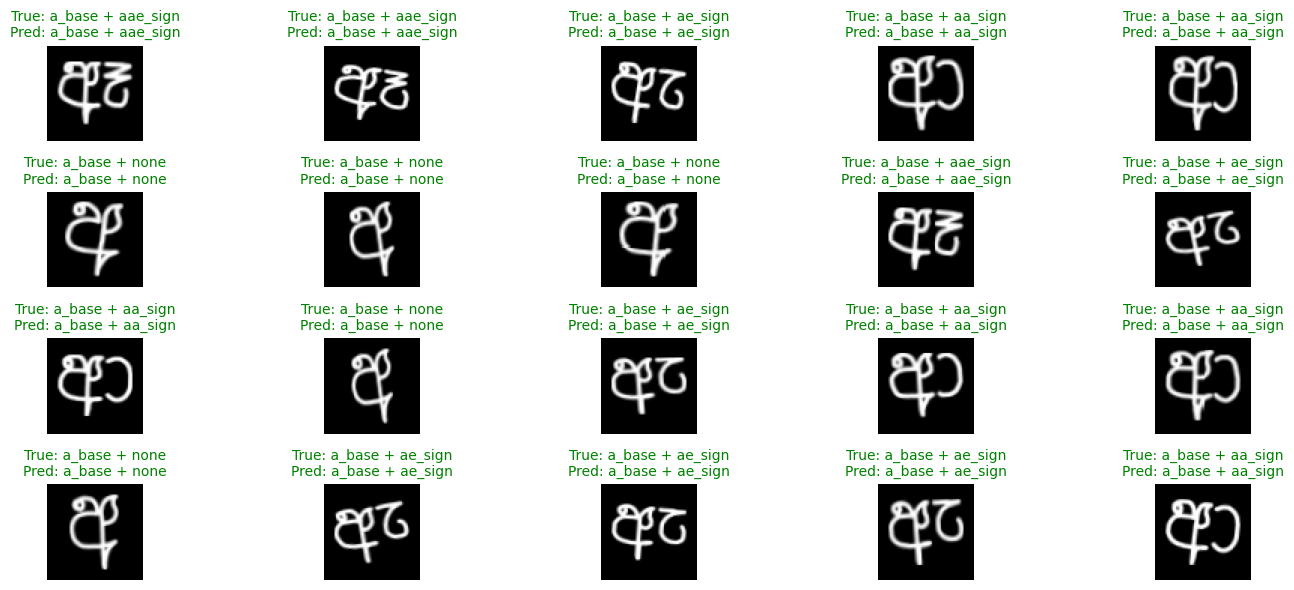

In [9]:
import matplotlib.pyplot as plt
import numpy as np


num_test_images = 20

# Test set එකෙන් අහඹු රූප තෝරාගැනීම
random_indices = np.random.choice(len(X_test), num_test_images, replace=False)

plt.figure(figsize=(15, 6))

for i, idx in enumerate(random_indices):
    # 1. රූපය සහ නියමිත ලේබලය ගැනීම
    img = X_test[idx]
    true_base = le_con.inverse_transform([y_con_test[idx]])[0]
    true_mod = le_mod.inverse_transform([y_mod_test[idx]])[0]

    # 2. මොඩලයෙන් අනාවැකි ලබා ගැනීම (Prediction)
    # (1, 64, 64, 1) ලෙස හැඩය සකස් කළ යුතුයි
    img_input = np.expand_dims(img, axis=0)
    predictions = model.predict(img_input, verbose=0)

    # 3. වැඩිම සම්භාවිතාව ඇති අගය තෝරා ගැනීම
    pred_base_idx = np.argmax(predictions[0]) # Head 1
    pred_mod_idx = np.argmax(predictions[1])  # Head 2

    # 4. අංක නැවත නම් බවට පත් කිරීම
    pred_base = le_con.inverse_transform([pred_base_idx])[0]
    pred_mod = le_mod.inverse_transform([pred_mod_idx])[0]

    # 5. රූපය පෙන්වීම
    ax = plt.subplot(4, 5, i + 1)
    plt.imshow(img.reshape(64, 64), cmap='gray')

    # නිවැරදි නම් කොළ පාටින්ද, වැරදි නම් රතු පාටින්ද පෙන්වයි
    color = 'green' if (true_base == pred_base and true_mod == pred_mod) else 'red'

    plt.title(f"True: {true_base} + {true_mod}\nPred: {pred_base} + {pred_mod}", color=color, fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [10]:
# මොඩලය Save කිරීම
model.save("sinhala_handwriting_model_v1.keras")
print("Model saved successfully as 'sinhala_handwriting_model_v1.keras'")


import pickle

label_mapping = {
    "consonant_classes": le_con.classes_,
    "modifier_classes": le_mod.classes_
}

with open("label_mapping.pkl", "wb") as f:
    pickle.dump(label_mapping, f)
print("Label mapping saved as 'label_mapping.pkl'")

Model saved successfully as 'sinhala_handwriting_model_v1.keras'
Label mapping saved as 'label_mapping.pkl'


In [ ]:
from google.colab import drive
import shutil
import os

# 1. Google Drive සම්බන්ධ කිරීම (Mount)
print("Google Drive සම්බන්ධ කරමින්...")
drive.mount('/content/drive')


destination_folder = "/content/drive/My Drive/Sinhala_AI_Model"

if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)
    print(f"Created new folder: {destination_folder}")
else:
    print(f"Folder found: {destination_folder}")


files_to_save = [
    "sinhala_handwriting_model_v1.keras",
    "label_mapping.pkl"
]

for file_name in files_to_save:
    if os.path.exists(file_name):
        # Drive එකට copy කිරීම
        shutil.copy(file_name, os.path.join(destination_folder, file_name))
        print(f"✅ සාර්ථකයි! {file_name} ගොනුව Google Drive වෙත Save විය.")
    else:
        print(f"❌ දෝෂයකි: {file_name} සොයාගත නොහැක. කරුණාකර පෙර පියවරේදී Save කලාදැයි බලන්න.")



Google Drive සම්බන්ධ කරමින්...
Mounted at /content/drive
Created new folder: /content/drive/My Drive/Sinhala_AI_Model
✅ සාර්ථකයි! sinhala_handwriting_model_v1.keras ගොනුව Google Drive වෙත Save විය.
✅ සාර්ථකයි! label_mapping.pkl ගොනුව Google Drive වෙත Save විය.
